In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

#### Image size of data set we have(256*256), and batch size we are taking 32

In [2]:
img_size=256
bch_size=32
channels=3
EPOCHS=50

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    'potato_leaves',shuffle=True,
    image_size=(img_size,img_size),
    batch_size=bch_size)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names

In [5]:
len(dataset)

68

2152 is distributed into 68 batches of size 32, 68*32=2176 so last batch has size less than 32 as it is not completely divisible

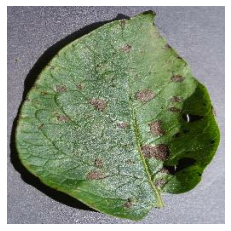

In [6]:
for image_batch,label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.axis('off')

we get it back in tensor type which has to be converted into numpy type for further operations

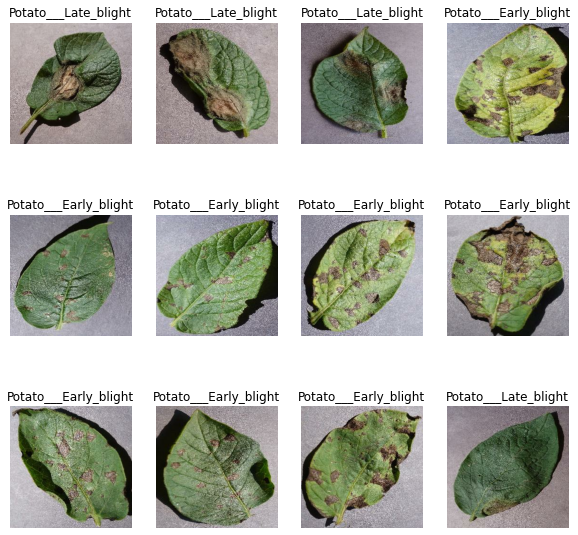

In [7]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

## 80% ==> training  20% ==> 10% validation, 10%test
## after every epoch we will validate

In [8]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_ds=dataset.take(54)
rest_ds=dataset.skip(54)

take(n) ==> [:n] |||
skip(n) ==>[n:]

### we would define a function for spliting data

In [10]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [11]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

### caching and prefetching to save time

In [12]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### resizeing and rescaling

In [24]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(img_size,img_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

### data augmentation (fliping the images and training the model with it also as test set can have flip imgs also)

In [14]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

### MODEL building

In [25]:
model=models.Sequential([resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=(bch_size,img_size,img_size,channels)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(3,activation='softmax'),
])
model.build(input_shape=(bch_size,img_size,img_size,channels))

In [26]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_48 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_48 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_49 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                

In [27]:
model.compile(
optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy']
)

In [28]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=bch_size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 77s 1s/step - loss: 0.8906 - accuracy: 0.5064 - val_loss: 0.8442 - val_accuracy: 0.5469
Epoch 2/50
54/54 [==============================] - 75s 1s/step - loss: 0.6788 - accuracy: 0.6782 - val_loss: 0.7866 - val_accuracy: 0.5729
Epoch 3/50
54/54 [==============================] - 79s 1s/step - loss: 0.4290 - accuracy: 0.8108 - val_loss: 0.3209 - val_accuracy: 0.8542
Epoch 4/50
54/54 [==============================] - 79s 1s/step - loss: 0.2975 - accuracy: 0.8814 - val_loss: 0.3191 - val_accuracy: 0.8490
Epoch 5/50
54/54 [==============================] - 79s 1s/step - loss: 0.2954 - accuracy: 0.8733 - val_loss: 0.3409 - val_accuracy: 0.8385
Epoch 6/50
54/54 [==============================] - 79s 1s/step - loss: 0.2090 - accuracy: 0.9190 - val_loss: 0.4605 - val_accuracy: 0.8125
Epoch 7/50
54/54 [==============================] - 79s 1s/step - loss: 0.2333 - accuracy: 0.9045 - val_loss: 0.2455 - val_accuracy: 0.9010
Epoch 8/50
54/54 [==

In [30]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 4s 282ms/step - loss: 0.0441 - accuracy: 0.9805


In [31]:
history

In [33]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
history.history['accuracy']

[0.5063657164573669,
 0.6782407164573669,
 0.8107638955116272,
 0.8813657164573669,
 0.8732638955116272,
 0.9189814925193787,
 0.9045138955116272,
 0.9276620149612427,
 0.9293981194496155,
 0.9456018805503845,
 0.9450231194496155,
 0.9733796119689941,
 0.9606481194496155,
 0.9814814925193787,
 0.9675925970077515,
 0.9704861044883728,
 0.9652777910232544,
 0.9768518805503845,
 0.9820601940155029,
 0.9646990895271301,
 0.9814814925193787,
 0.9826388955116272,
 0.9861111044883728,
 0.9913194179534912,
 0.9901620149612427,
 0.9797453880310059,
 0.9820601940155029,
 0.9901620149612427,
 0.9768518805503845,
 0.9814814925193787,
 0.9930555820465088,
 0.9930555820465088,
 0.9930555820465088,
 0.9855324029922485,
 0.9884259104728699,
 0.9953703880310059,
 0.9878472089767456,
 0.9849537014961243,
 0.9936342835426331,
 0.9965277910232544,
 0.9849537014961243,
 0.9918981194496155,
 0.9930555820465088,
 0.9930555820465088,
 0.9826388955116272,
 0.984375,
 0.9936342835426331,
 0.9959490895271301,
 0

### ploting accuracy and loss

Text(0.5, 1.0, 'Training and Validation Loss')

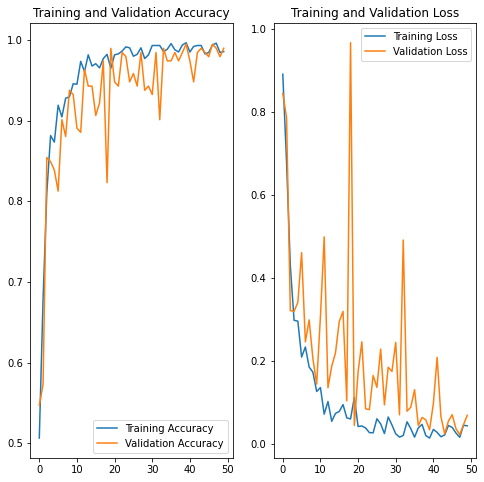

In [37]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

First Image to prtedict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 265ms/step
predicted label: Potato___Early_blight


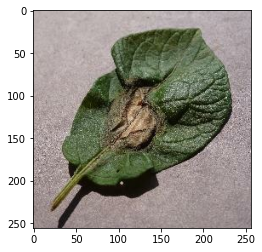

In [45]:
import numpy as np
for images_batch,label_batch in test_ds.take(1):
    first_image=image_batch[0].numpy().astype('uint8')
    first_label=label_batch[0].numpy()
    
    print('First Image to prtedict')
    plt.imshow(first_image)
    print('actual label:',class_names[first_label])
    
    batch_prediction=model.predict(images_batch)
    print('predicted label:',class_names[np.argmax(batch_prediction[0])])

In [46]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)# create a batch
    
    predictions=model.predict(img_array)
    
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 32ms/step


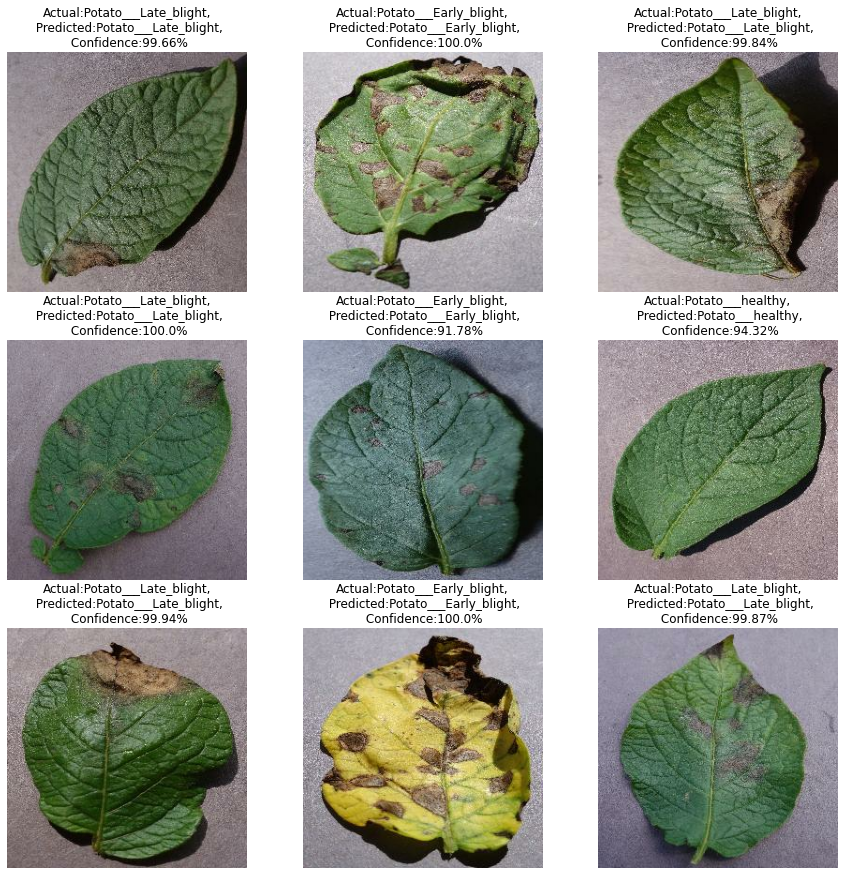

In [54]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        
        plt.title(f'Actual:{actual_class},\n Predicted:{predicted_class},\n Confidence:{confidence}%')
        plt.axis('off')